In [1]:
'''
Import libraries
'''
#!pip install --quiet optuna
#!pip install --quiet yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import yfinance as yf
import os.path
import optuna
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from optuna.trial import TrialState
from optuna.visualization import plot_param_importances


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"[INFO]: Using {device} device")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.1 MB/s eta 0:00:00
[INFO]: Using cpu device


In [2]:
'''
Download data from yfinance
'''

path = '../data/yfinance_stocks_data.csv'
tickers_list = ['^GSPC', 'AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL', 'GOOG', 'LLY', 'JPM',
                'XOM', 'UNH', 'PG', 'JNJ', 'HD', 'WMT', 'MRK', 'NFLX', 'KO',
                'BAC', 'CVX', 'CRM', 'ADBE', 'PEP', 'TMO', 'AMD', 'LIN', 'ORCL',
                'ACN', 'MCD', 'QCOM', 'ABT', 'WFC', 'GE', 'CSCO', 'INTU', 'TXN',
                'DHR', 'IBM', 'AMGN', 'VZ', 'AMAT']

def download_db(path,tickers_list):
  if(not os.path.isfile(path)):
    df = yf.download(tickers=tickers_list,actions=True,start='2005-10-10',end='2020-05-04')['Adj Close']
    df.to_csv(path, index=True)
    #print(df.head())

download_db(path, tickers_list)

[*********************100%***********************]  41 of 41 completed


In [3]:
'''
Prepare dataloader from csv file
'''

def get_data(path, symbol):
  #Reades csv and extracts Date and symbol colunms
  data = pd.read_csv(path)
  data = data[['Date', symbol]]
  data['Date'] = pd.to_datetime(data['Date'])

  #Change "Close price" to "Gain/Loss" (represents daily change in %)
  data['Gain/Loss'] = data[symbol].pct_change(fill_method=None) * 100
  data = data.rename(columns={symbol: 'Close'})
  data = data.dropna(subset=['Gain/Loss'])

  return data[['Date', 'Gain/Loss']]


def prepare_df(df, n_steps):
  #Extends DataFrame to include a lookback columns to the past days

  df = dc(df)
  df.set_index('Date', inplace=True)

  for i in range(1, n_steps+1):
    df[f'Gain/Loss(t-{i})'] = df['Gain/Loss'].shift(i)

  df.dropna(inplace=True)

  return df


class TimeSeriesDS(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, i):
    return self.x[i], self.y[i]


def prepare_data(data, scaler, lookback):

  shifted_df = prepare_df(data, lookback)
  shifted_df = scaler.fit_transform(shifted_df)

  x = shifted_df[:, 1:]
  y = shifted_df[:, 0]

  x = dc(np.flip(x, axis = 1))  # split to train, validation and test sets:

  i = int(len(x) * 0.8)
  j = int(len(x) * 0.9)

  x_train = x[: i]
  x_val = x[i : j]
  x_test = x[j :]

  y_train = y[: i]
  y_val = y[i : j]
  y_test = y[j :]

  return x_train, x_val, x_test, y_train, y_val, y_test


def get_dataloader(lookback, batch_size, x_train, x_val, x_test, y_train, y_val, y_test):
  # reshape to the proper size and transform from np arrays to tensors:

  x_train = torch.tensor(x_train.reshape((-1, lookback, 1))).float()
  x_val = torch.tensor(x_val.reshape((-1, lookback, 1))).float()
  x_test = torch.tensor(x_test.reshape((-1, lookback, 1))).float()

  y_train = torch.tensor(y_train.reshape((-1, 1))).float()
  y_val = torch.tensor(y_val.reshape((-1, 1))).float()
  y_test = torch.tensor(y_test.reshape((-1, 1))).float()


  # Cast data to Dataset and dataloader:
  train_DS = TimeSeriesDS(x_train, y_train)
  val_DS = TimeSeriesDS(x_val, y_val)
  test_DS = TimeSeriesDS(x_test, y_test)

  #train_DS
  train_loader = DataLoader(train_DS, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_DS, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_DS, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

def get_loader_list(lookback, batch_size,tickers_list, scaler):
  # Returns dataloader list (one for each tocken)

  train_loader_list = []
  val_loader_list = []
  test_loader_list = []

  for i in range(len(tickers_list)):
    data = get_data(path, tickers_list[i])

    x_train, x_val, x_test, y_train, y_val, y_test = prepare_data(data, scaler, lookback)
    train_loader, val_loader, test_loader = get_dataloader(lookback, batch_size, x_train, x_val, x_test, y_train, y_val, y_test)

    train_loader_list.append(train_loader)
    val_loader_list.append(val_loader)
    test_loader_list.append(test_loader)

  return train_loader_list, val_loader_list, test_loader_list

In [4]:
'''
Define LSTM module
'''

class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                        num_layers=num_stacked_layers,batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    h0 = torch.zeros(self.num_stacked_layers,x.size(0),self.hidden_size).requires_grad_().to(device)
    c0 = torch.zeros(self.num_stacked_layers,x.size(0),self.hidden_size).requires_grad_().to(device)
    x = x.to(device)
    out, _ = self.lstm(x, (h0.detach(), c0.detach()))

    return self.fc(out[:, -1,:])

In [5]:
'''
Training function
'''

def train(model,loss_func, optimizer, scheduler, train_loader_list, val_loader_list, params, trial=None):
  # Used for training and tuning h-params using Optuna via the trial parameter
  val_loss_arr = np.zeros(params['epochs'])
  train_loss_arr = np.zeros(params['epochs'])

  for epoch in range(params['epochs']):
    running_loss_train = 0.0
    running_loss_val = 0.0

    model.train(True)
    for train_loader in train_loader_list:
      for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_func(output, y_batch)

        running_loss_train += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.train(False)
    for val_loader in val_loader_list:
      for batch_index, batch in enumerate(val_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
          output = model(x_batch)
          loss = loss_func(output, y_batch)
          running_loss_val += loss

    running_loss_train = running_loss_train / (len(train_loader_list) * len(train_loader_list[0]))
    running_loss_val = running_loss_val / (len(val_loader_list) * len(val_loader_list[0]))
    train_loss_arr[epoch] = running_loss_train
    val_loss_arr[epoch] = running_loss_val
    print(f'Epoch {epoch + 1} finished, Train loss = {running_loss_train}, Validation loss = {running_loss_val}')
    scheduler.step()

    if(trial):
      trial.report(running_loss_val, epoch)
      # Handle pruning based on the intermediate value.
      if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

  return train_loss_arr, val_loss_arr

In [30]:
'''
Optimize hyper-params using Optuna
'''

def objective(trial):
  # Used for tuning h-params using Optuna
  params = {
        "input_size": 1,
        "epochs": 15,
        "hidden_size": trial.suggest_categorical("hidden_size", [2,4,8,16]),
        "num_stacked_layers": trial.suggest_categorical("num_stacked_layers", [1,2,4]),
        "lookback": trial.suggest_int("lookback", 3, 30),
        "optimizer_name": trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop", "SGD"]),
        "batch_size": trial.suggest_categorical("batch_size", [16,32,64]),
        "lr": trial.suggest_float("lr", 1e-5, 1e-1, log=True),
        "scheduler_step_size": trial.suggest_int("scheduler_step_size", 1, 10),
        "scheduler_gamma": trial.suggest_float("scheduler_gamma", 0.5, 1),
    }

  loss_func = nn.MSELoss()
  model = LSTM(params['input_size'], params['hidden_size'], params['num_stacked_layers']).to(device)
  optimizer = getattr(torch.optim, params['optimizer_name'])(model.parameters(), lr=params['lr'])
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params['scheduler_step_size'], gamma=params['scheduler_gamma'])

  #prepare data
  scaler = MinMaxScaler(feature_range=(-1,1))
  train_loader_list, val_loader_list, test_loader_list = get_loader_list(params['lookback'], params['batch_size'],tickers_list, scaler)

  _, val_loss_arr  = train(model,loss_func, optimizer, scheduler, train_loader_list, val_loader_list, params, trial)
  return val_loss_arr[-1]


# Tune h-params and show results

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, timeout=6000)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

fig = plot_param_importances(study)
fig.show()

[I 2024-11-07 09:13:37,843] A new study created in memory with name: no-name-abc71d77-8af7-4b1c-ac5a-7b6b6699ff35


Epoch 1 finished, Train loss = 0.075589120388031, Validation loss = 0.038148537278175354
Epoch 2 finished, Train loss = 0.037941720336675644, Validation loss = 0.03314243629574776
Epoch 3 finished, Train loss = 0.036674994975328445, Validation loss = 0.03313209488987923
Epoch 4 finished, Train loss = 0.03673289343714714, Validation loss = 0.03317800909280777
Epoch 5 finished, Train loss = 0.03675990179181099, Validation loss = 0.033190008252859116
Epoch 6 finished, Train loss = 0.0367664135992527, Validation loss = 0.033192556351423264
Epoch 7 finished, Train loss = 0.0367678627371788, Validation loss = 0.03319305181503296
Epoch 8 finished, Train loss = 0.03676803410053253, Validation loss = 0.03319321200251579
Epoch 9 finished, Train loss = 0.03678153082728386, Validation loss = 0.03318547457456589
Epoch 10 finished, Train loss = 0.03677744418382645, Validation loss = 0.033183638006448746
Epoch 11 finished, Train loss = 0.03677649423480034, Validation loss = 0.033183224499225616
Epoch

[I 2024-11-07 09:22:13,517] Trial 0 finished with value: 0.033183127641677856 and parameters: {'hidden_size': 2, 'num_stacked_layers': 4, 'lookback': 23, 'optimizer': 'SGD', 'batch_size': 32, 'lr': 0.00015447868982284497, 'scheduler_step_size': 8, 'scheduler_gamma': 0.9379870437430873}. Best is trial 0 with value: 0.033183127641677856.


Epoch 15 finished, Train loss = 0.03677607700228691, Validation loss = 0.033183127641677856
Epoch 1 finished, Train loss = 0.03619730472564697, Validation loss = 0.032937027513980865
Epoch 2 finished, Train loss = 0.03549986332654953, Validation loss = 0.032339226454496384
Epoch 3 finished, Train loss = 0.034693628549575806, Validation loss = 0.030808769166469574
Epoch 4 finished, Train loss = 0.029364464804530144, Validation loss = 0.021997947245836258
Epoch 5 finished, Train loss = 0.01511671394109726, Validation loss = 0.028075844049453735
Epoch 6 finished, Train loss = 0.013709279708564281, Validation loss = 0.028707288205623627
Epoch 7 finished, Train loss = 0.013417820446193218, Validation loss = 0.025295177474617958
Epoch 8 finished, Train loss = 0.013234023004770279, Validation loss = 0.021657181903719902
Epoch 9 finished, Train loss = 0.013110427185893059, Validation loss = 0.018307145684957504
Epoch 10 finished, Train loss = 0.012984476052224636, Validation loss = 0.017643878

[I 2024-11-07 09:27:15,787] Trial 1 finished with value: 0.011759518645703793 and parameters: {'hidden_size': 8, 'num_stacked_layers': 4, 'lookback': 16, 'optimizer': 'Adam', 'batch_size': 64, 'lr': 0.0001255192959455564, 'scheduler_step_size': 8, 'scheduler_gamma': 0.980998747777825}. Best is trial 1 with value: 0.011759518645703793.


Epoch 15 finished, Train loss = 0.01266464963555336, Validation loss = 0.011759518645703793
Epoch 1 finished, Train loss = 0.013975881971418858, Validation loss = 0.06531087309122086
Epoch 2 finished, Train loss = 0.01340035255998373, Validation loss = 0.04134202376008034
Epoch 3 finished, Train loss = 0.013101537711918354, Validation loss = 0.07787136733531952
Epoch 4 finished, Train loss = 0.012793513014912605, Validation loss = 0.018017083406448364
Epoch 5 finished, Train loss = 0.012745878659188747, Validation loss = 0.01894737407565117
Epoch 6 finished, Train loss = 0.012932988815009594, Validation loss = 0.015408876352012157
Epoch 7 finished, Train loss = 0.012906667776405811, Validation loss = 0.01458606868982315
Epoch 8 finished, Train loss = 0.012597591616213322, Validation loss = 0.013261155225336552
Epoch 9 finished, Train loss = 0.01251790951937437, Validation loss = 0.015029620379209518
Epoch 10 finished, Train loss = 0.012628613971173763, Validation loss = 0.0140320807695

[I 2024-11-07 09:31:53,293] Trial 2 finished with value: 0.01307990588247776 and parameters: {'hidden_size': 4, 'num_stacked_layers': 2, 'lookback': 19, 'optimizer': 'RMSprop', 'batch_size': 64, 'lr': 0.007906693586771228, 'scheduler_step_size': 5, 'scheduler_gamma': 0.5874205575252839}. Best is trial 1 with value: 0.011759518645703793.


Epoch 15 finished, Train loss = 0.012300818227231503, Validation loss = 0.01307990588247776
Epoch 1 finished, Train loss = 0.013669476844370365, Validation loss = 0.015396470203995705
Epoch 2 finished, Train loss = 0.012499411590397358, Validation loss = 0.020374802872538567
Epoch 3 finished, Train loss = 0.012433330528438091, Validation loss = 0.02584422193467617
Epoch 4 finished, Train loss = 0.012391678988933563, Validation loss = 0.026692211627960205
Epoch 5 finished, Train loss = 0.012339883483946323, Validation loss = 0.022000884637236595
Epoch 6 finished, Train loss = 0.012405752204358578, Validation loss = 0.028669418767094612
Epoch 7 finished, Train loss = 0.012377995066344738, Validation loss = 0.024259699508547783
Epoch 8 finished, Train loss = 0.012327303178608418, Validation loss = 0.024727242067456245
Epoch 9 finished, Train loss = 0.012336009182035923, Validation loss = 0.029592521488666534
Epoch 10 finished, Train loss = 0.012303738854825497, Validation loss = 0.0263230

[I 2024-11-07 09:37:04,121] Trial 3 finished with value: 0.017875773832201958 and parameters: {'hidden_size': 16, 'num_stacked_layers': 2, 'lookback': 29, 'optimizer': 'RMSprop', 'batch_size': 64, 'lr': 0.00031368863136372157, 'scheduler_step_size': 10, 'scheduler_gamma': 0.7571094322648846}. Best is trial 1 with value: 0.011759518645703793.


Epoch 15 finished, Train loss = 0.012193665839731693, Validation loss = 0.017875773832201958
Epoch 1 finished, Train loss = 0.019916508346796036, Validation loss = 0.06376080214977264
Epoch 2 finished, Train loss = 0.016982577741146088, Validation loss = 0.044199902564287186
Epoch 3 finished, Train loss = 0.014758087694644928, Validation loss = 0.026837237179279327
Epoch 4 finished, Train loss = 0.013758722692728043, Validation loss = 0.020004654303193092
Epoch 5 finished, Train loss = 0.013586640357971191, Validation loss = 0.01465501356869936
Epoch 6 finished, Train loss = 0.013537381775677204, Validation loss = 0.014081156812608242
Epoch 7 finished, Train loss = 0.013386302627623081, Validation loss = 0.014086388982832432
Epoch 8 finished, Train loss = 0.013302416540682316, Validation loss = 0.014543035998940468
Epoch 9 finished, Train loss = 0.013335397467017174, Validation loss = 0.013545378111302853
Epoch 10 finished, Train loss = 0.01325399149209261, Validation loss = 0.01368473

[I 2024-11-07 09:39:48,742] Trial 4 finished with value: 0.013708168640732765 and parameters: {'hidden_size': 16, 'num_stacked_layers': 1, 'lookback': 27, 'optimizer': 'SGD', 'batch_size': 64, 'lr': 0.020382529872400548, 'scheduler_step_size': 4, 'scheduler_gamma': 0.734717577476889}. Best is trial 1 with value: 0.011759518645703793.


Epoch 15 finished, Train loss = 0.01306922361254692, Validation loss = 0.013708168640732765
Epoch 1 finished, Train loss = 0.03689324110746384, Validation loss = 0.020512310788035393
Epoch 2 finished, Train loss = 0.017331495881080627, Validation loss = 0.011678725481033325
Epoch 3 finished, Train loss = 0.013636661693453789, Validation loss = 0.013176806271076202
Epoch 4 finished, Train loss = 0.013583806343376637, Validation loss = 0.014770738780498505
Epoch 5 finished, Train loss = 0.013520182110369205, Validation loss = 0.015014272183179855
Epoch 6 finished, Train loss = 0.013447951525449753, Validation loss = 0.014701205305755138
Epoch 7 finished, Train loss = 0.013356605544686317, Validation loss = 0.015386776067316532
Epoch 8 finished, Train loss = 0.013307538814842701, Validation loss = 0.01444049458950758
Epoch 9 finished, Train loss = 0.013237298466265202, Validation loss = 0.014338082633912563
Epoch 10 finished, Train loss = 0.013205448165535927, Validation loss = 0.01393428

[I 2024-11-07 09:42:28,357] Trial 5 finished with value: 0.013533233664929867 and parameters: {'hidden_size': 4, 'num_stacked_layers': 1, 'lookback': 15, 'optimizer': 'Adam', 'batch_size': 64, 'lr': 0.00025774786508971564, 'scheduler_step_size': 6, 'scheduler_gamma': 0.9339965428592452}. Best is trial 1 with value: 0.011759518645703793.


Epoch 15 finished, Train loss = 0.012981842271983624, Validation loss = 0.013533233664929867
Epoch 1 finished, Train loss = 0.01920475624501705, Validation loss = 0.01587926223874092
Epoch 2 finished, Train loss = 0.013143478892743587, Validation loss = 0.012050632387399673
Epoch 3 finished, Train loss = 0.01299260463565588, Validation loss = 0.012586788274347782
Epoch 4 finished, Train loss = 0.012987751513719559, Validation loss = 0.01301250047981739
Epoch 5 finished, Train loss = 0.012939847074449062, Validation loss = 0.012931006960570812
Epoch 6 finished, Train loss = 0.01294613629579544, Validation loss = 0.01243006344884634
Epoch 7 finished, Train loss = 0.012818467803299427, Validation loss = 0.012408015318214893
Epoch 8 finished, Train loss = 0.01285221241414547, Validation loss = 0.013501925393939018
Epoch 9 finished, Train loss = 0.012839176692068577, Validation loss = 0.01628442294895649
Epoch 10 finished, Train loss = 0.012824248522520065, Validation loss = 0.0153310876339

[I 2024-11-07 09:45:37,806] Trial 6 finished with value: 0.013125238008797169 and parameters: {'hidden_size': 16, 'num_stacked_layers': 1, 'lookback': 28, 'optimizer': 'Adam', 'batch_size': 64, 'lr': 0.0001999799373351049, 'scheduler_step_size': 5, 'scheduler_gamma': 0.8437289321172333}. Best is trial 1 with value: 0.011759518645703793.


Epoch 15 finished, Train loss = 0.012531868182122707, Validation loss = 0.013125238008797169


[I 2024-11-07 09:45:49,163] Trial 7 pruned. 


Epoch 1 finished, Train loss = 0.014551635831594467, Validation loss = 0.11167947202920914


[I 2024-11-07 09:46:19,403] Trial 8 pruned. 


Epoch 1 finished, Train loss = 0.02917242795228958, Validation loss = 0.04608668014407158
Epoch 1 finished, Train loss = 0.19536727666854858, Validation loss = 0.02785102091729641
Epoch 2 finished, Train loss = 0.027992142364382744, Validation loss = 0.01970917358994484
Epoch 3 finished, Train loss = 0.02034882828593254, Validation loss = 0.013998224399983883
Epoch 4 finished, Train loss = 0.017043374478816986, Validation loss = 0.012352285906672478
Epoch 5 finished, Train loss = 0.01620088890194893, Validation loss = 0.011796128004789352
Epoch 6 finished, Train loss = 0.015875661745667458, Validation loss = 0.011501247063279152
Epoch 7 finished, Train loss = 0.015685779973864555, Validation loss = 0.011320850811898708
Epoch 8 finished, Train loss = 0.015562311746180058, Validation loss = 0.011205404065549374
Epoch 9 finished, Train loss = 0.015484040603041649, Validation loss = 0.011126752011477947
Epoch 10 finished, Train loss = 0.015427586622536182, Validation loss = 0.0110738836228

[I 2024-11-07 09:50:31,743] Trial 9 finished with value: 0.01098154578357935 and parameters: {'hidden_size': 2, 'num_stacked_layers': 1, 'lookback': 29, 'optimizer': 'Adam', 'batch_size': 32, 'lr': 0.00013048362165502764, 'scheduler_step_size': 1, 'scheduler_gamma': 0.7143892608702528}. Best is trial 9 with value: 0.01098154578357935.


Epoch 15 finished, Train loss = 0.015319540165364742, Validation loss = 0.01098154578357935
Epoch 1 finished, Train loss = 0.035277966409921646, Validation loss = 0.029350019991397858


[I 2024-11-07 09:51:19,345] Trial 10 pruned. 


Epoch 2 finished, Train loss = 0.03273828700184822, Validation loss = 0.02803376503288746


[I 2024-11-07 09:51:55,448] Trial 11 pruned. 


Epoch 1 finished, Train loss = 0.036541275680065155, Validation loss = 0.03304365277290344
Epoch 1 finished, Train loss = 0.032074935734272, Validation loss = 0.022064313292503357
Epoch 2 finished, Train loss = 0.017030449584126472, Validation loss = 0.022888392210006714
Epoch 3 finished, Train loss = 0.01613505370914936, Validation loss = 0.024522166699171066


[I 2024-11-07 09:55:09,407] Trial 12 pruned. 


Epoch 4 finished, Train loss = 0.01571083627641201, Validation loss = 0.024418866261839867


[I 2024-11-07 09:55:41,090] Trial 13 pruned. 


Epoch 1 finished, Train loss = 0.019773516803979874, Validation loss = 0.11911147087812424


[I 2024-11-07 09:56:07,238] Trial 14 pruned. 


Epoch 1 finished, Train loss = 0.028324676677584648, Validation loss = 0.07663995772600174
Epoch 1 finished, Train loss = 0.02369004115462303, Validation loss = 0.013977008871734142
Epoch 2 finished, Train loss = 0.013507789000868797, Validation loss = 0.013921253383159637
Epoch 3 finished, Train loss = 0.012916815467178822, Validation loss = 0.012980425730347633
Epoch 4 finished, Train loss = 0.012777167372405529, Validation loss = 0.01167182344943285
Epoch 5 finished, Train loss = 0.012659085914492607, Validation loss = 0.011799479834735394
Epoch 6 finished, Train loss = 0.012590436264872551, Validation loss = 0.012909457087516785
Epoch 7 finished, Train loss = 0.01254569087177515, Validation loss = 0.013746262528002262
Epoch 8 finished, Train loss = 0.012515065260231495, Validation loss = 0.013591810129582882
Epoch 9 finished, Train loss = 0.01247650571167469, Validation loss = 0.012221299111843109
Epoch 10 finished, Train loss = 0.012439634650945663, Validation loss = 0.01367491763

[I 2024-11-07 10:02:19,275] Trial 15 finished with value: 0.012409395538270473 and parameters: {'hidden_size': 8, 'num_stacked_layers': 1, 'lookback': 18, 'optimizer': 'Adam', 'batch_size': 16, 'lr': 5.515503217431549e-05, 'scheduler_step_size': 10, 'scheduler_gamma': 0.7962260021438885}. Best is trial 9 with value: 0.01098154578357935.


Epoch 15 finished, Train loss = 0.012334892526268959, Validation loss = 0.012409395538270473


[I 2024-11-07 10:02:52,647] Trial 16 pruned. 


Epoch 1 finished, Train loss = 0.026613228023052216, Validation loss = 0.037629589438438416


[I 2024-11-07 10:03:35,559] Trial 17 pruned. 


Epoch 1 finished, Train loss = 0.07019727677106857, Validation loss = 0.03361792862415314


[I 2024-11-07 10:03:51,920] Trial 18 pruned. 


Epoch 1 finished, Train loss = 0.01484863180667162, Validation loss = 0.0744621679186821


[I 2024-11-07 10:04:25,223] Trial 19 pruned. 


Epoch 1 finished, Train loss = 0.04292532801628113, Validation loss = 0.03374435380101204
Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  11
  Number of complete trials:  9
Best trial:
  Value:  0.01098154578357935
  Params: 
    hidden_size: 2
    num_stacked_layers: 1
    lookback: 29
    optimizer: Adam
    batch_size: 32
    lr: 0.00013048362165502764
    scheduler_step_size: 1
    scheduler_gamma: 0.7143892608702528


[INFO]: 43 total parameters.
Epoch 1 finished, Train loss = 0.12871050834655762, Validation loss = 0.025599243119359016
Epoch 2 finished, Train loss = 0.027506383135914803, Validation loss = 0.02186514250934124
Epoch 3 finished, Train loss = 0.023419376462697983, Validation loss = 0.017535878345370293
Epoch 4 finished, Train loss = 0.019902870059013367, Validation loss = 0.01452462375164032
Epoch 5 finished, Train loss = 0.017652560025453568, Validation loss = 0.01271450612694025
Epoch 6 finished, Train loss = 0.016363121569156647, Validation loss = 0.011708145961165428
Epoch 7 finished, Train loss = 0.015670763328671455, Validation loss = 0.011171241290867329
Epoch 8 finished, Train loss = 0.015299638733267784, Validation loss = 0.010880189016461372
Epoch 9 finished, Train loss = 0.015094997361302376, Validation loss = 0.010718396864831448
Epoch 10 finished, Train loss = 0.014979761093854904, Validation loss = 0.010621384717524052
Epoch 11 finished, Train loss = 0.01490751188248396, V

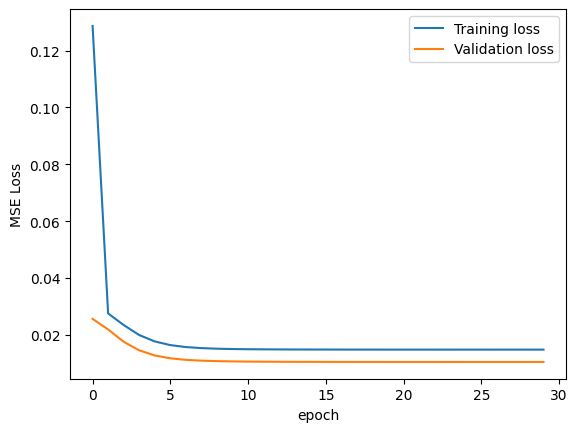

In [6]:
'''
Train model with best params
'''

# Define params based on best params from Optuna
params = {
        "input_size": 1,
        "epochs": 30,
        "hidden_size": 2,
        "num_stacked_layers": 1,
        "lookback": 29,
        "optimizer_name": 'Adam',
        "batch_size": 32,
        "lr": 0.00013048362165502764,
        "scheduler_step_size": 1,
        "scheduler_gamma": 0.7143892608702528
    }


loss_func = nn.MSELoss()
model = LSTM(params['input_size'], params['hidden_size'], params['num_stacked_layers']).to(device)
optimizer = getattr(torch.optim, params['optimizer_name'])(model.parameters(), lr=params['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params['scheduler_step_size'], gamma=params['scheduler_gamma'])

total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")

#prepare data
scaler = MinMaxScaler(feature_range=(-1,1))
train_loader_list, val_loader_list, test_loader_list = get_loader_list(params['lookback'], params['batch_size'],tickers_list, scaler)

train_loss_arr, val_loss_arr = train(model,loss_func, optimizer, scheduler, train_loader_list, val_loader_list, params)



#plt.semilogy(train_loss, label='Training loss')
#plt.semilogy(val_loss, label='Validation loss')
plt.plot(train_loss_arr, label='Training loss')
plt.plot(val_loss_arr, label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

MSE predictions vs actual Gain/Loss on Validation set:    0.005350451
MSE constant zero vs actual Gain/Loss on Validation set:    0.004963351
MSE avg_Gain/Loss vs actual Gain/Loss on Validation set:    0.0049523595


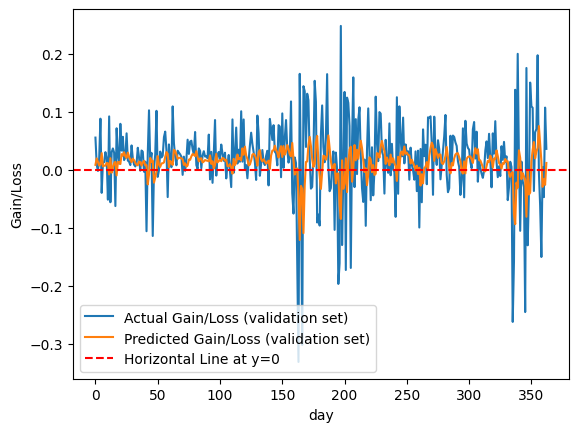

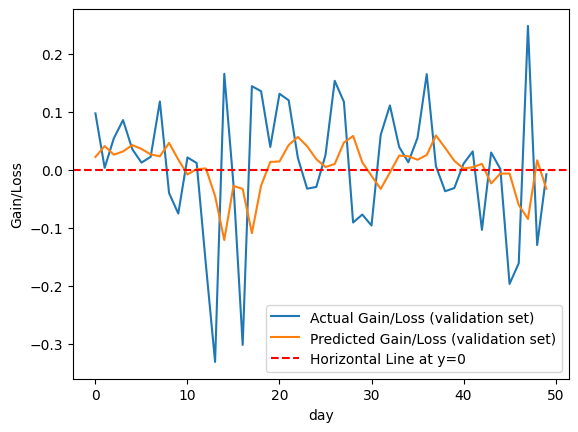

In [8]:
model.train(False)
predictions_val = []
actual_val = []

for batch_index, batch in enumerate(val_loader_list[0]):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  with torch.no_grad():
    output = model(x_batch)
    predictions_val.extend(output.cpu().numpy().flatten())
    actual_val.extend(y_batch.cpu().numpy().flatten())

def calc_MSE(predictions, actual):
  return np.mean((np.array(predictions) - np.array(actual)) ** 2)

print("MSE predictions vs actual Gain/Loss on Validation set:   ", calc_MSE(predictions_val, actual_val))
print("MSE constant zero vs actual Gain/Loss on Validation set:   ", calc_MSE(np.zeros_like(actual_val), actual_val))
avg_return = 0.1 / 365 # Avarage stock market return is about 10% annually
print("MSE avg_Gain/Loss vs actual Gain/Loss on Validation set:   ", calc_MSE(np.ones_like(actual_val) * avg_return, actual_val))



plt.plot(actual_val, label='Actual Gain/Loss (validation set)')
plt.plot(predictions_val, label='Predicted Gain/Loss (validation set)')
plt.axhline(y=0, color='r', linestyle='--', label='Horizontal Line at y=0')
plt.xlabel('day')
plt.ylabel('Gain/Loss')
plt.legend()
plt.show()


plt.plot(actual_val[150:200], label='Actual Gain/Loss (validation set)')
plt.plot(predictions_val[150:200], label='Predicted Gain/Loss (validation set)')
plt.axhline(y=0, color='r', linestyle='--', label='Horizontal Line at y=0')
plt.xlabel('day')
plt.ylabel('Gain/Loss')
plt.legend()
plt.show()

MSE predictions vs actual Gain/Loss on Test set:    0.028338367
MSE constant zero vs actual Gain/Loss on Test set:    0.023763437
MSE avg_Gain/Loss vs actual Gain/Loss on Test set:    0.023752922


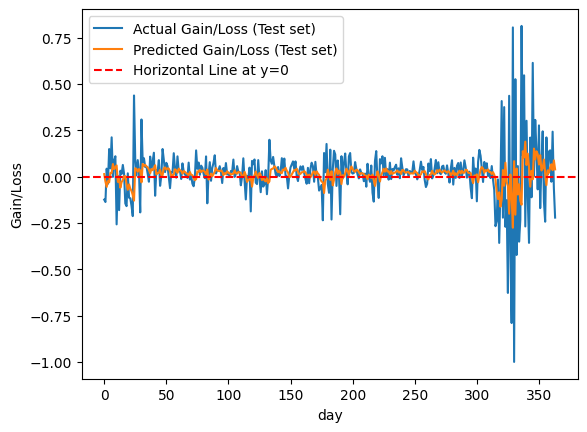

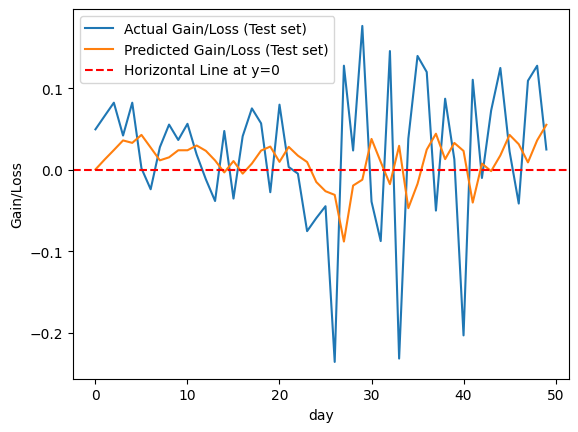

In [9]:
model.train(False)
predictions_test = []
actual_test = []

for batch_index, batch in enumerate(test_loader_list[0]):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  with torch.no_grad():
    output = model(x_batch)
    predictions_test.extend(output.cpu().numpy().flatten())
    actual_test.extend(y_batch.cpu().numpy().flatten())

def calc_MSE(predictions, actual):
  return np.mean((np.array(predictions) - np.array(actual)) ** 2)

print("MSE predictions vs actual Gain/Loss on Test set:   ", calc_MSE(predictions_test, actual_test))
print("MSE constant zero vs actual Gain/Loss on Test set:   ", calc_MSE(np.zeros_like(actual_test), actual_test))
avg_return = 0.1 / 365 # Avarage stock market return is about 10% annually
print("MSE avg_Gain/Loss vs actual Gain/Loss on Test set:   ", calc_MSE(np.ones_like(actual_test) * avg_return, actual_test))



plt.plot(actual_test, label='Actual Gain/Loss (Test set)')
plt.plot(predictions_test, label='Predicted Gain/Loss (Test set)')
plt.axhline(y=0, color='r', linestyle='--', label='Horizontal Line at y=0')
plt.xlabel('day')
plt.ylabel('Gain/Loss')
plt.legend()
plt.show()


plt.plot(actual_test[150:200], label='Actual Gain/Loss (Test set)')
plt.plot(predictions_test[150:200], label='Predicted Gain/Loss (Test set)')
plt.axhline(y=0, color='r', linestyle='--', label='Horizontal Line at y=0')
plt.xlabel('day')
plt.ylabel('Gain/Loss')
plt.legend()
plt.show()